In [1]:
using PyPlot
using LinearAlgebra
using Statistics
using Random
import Base.MathConstants.e

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/cdesa/.julia/packages/PyPlot/XHEG0/src/init.jl:192


# Adaptive Learning Rates

Let's look at using stochastic gradient descent with various methods to optimize logistic regression.
First, we'll generate a training set at random from the generative model associated with logistic regression.
(The same generative model we used for Notebook 6.)

Except: here to create some imbalance in the examples, we'll adjust the sampled $X$ to have different variances in different coordinates.

In [2]:
# generate the data
Random.seed!(424242)
d = 50;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt.(sum(X.^2; dims=2));
Y = (1 ./ (1 .+ exp.(-X * wtrue)) .>= rand(N)) .* 2 .- 1;
sigma = 1e-4;

Let's do logistic regression with regularization here, just as we did before to study hyperparameter optimization.

In [3]:
w0 = randn(d);

In [4]:
function sgd_logreg(w0, alpha0, gamma, X, Y, sigma, niters, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        alpha = alpha0 / (1 + gamma * (k-1));
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w = (1 - alpha * sigma) * w + alpha * xi * yi / (1 .+ exp.(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

function adagrad_logreg(w0, alpha, X, Y, sigma, niters, wopt)
    w = w0;
    (N, d) = size(X);
    r = zeros(d);
    dist_to_optimum = zeros(niters);
    for k = 1:niters
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        g = sigma * w - xi * yi / (1 .+ exp.(yi * dot(xi, w)));
        r += g.^2;
        w -= alpha * g ./ (sqrt.(r) .+ 1e-10); 
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

adagrad_logreg (generic function with 1 method)

In [5]:
# find the true minimum
function newton_logreg(w0, X, Y, sigma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 .+ exp.(Y .* (X * w)))) + N * sigma * w;
        H = X' * ((1 ./ ((1 .+ exp.(Y .* (X * w))) .* (1 .+ exp.(-Y .* (X * w))))) .* X) + N * sigma * I;
        w = w - H \ g;
        println("gradient norm: $(norm(g))")
    end
    return w
end

newton_logreg (generic function with 1 method)

In [6]:
wopt = newton_logreg(wtrue, X, Y, sigma, 20);

gradient norm: 2500.0057447159948
gradient norm: 584.5684610195854
gradient norm: 163.16540824030486
gradient norm: 59.78553169886596
gradient norm: 16.463182017766883
gradient norm: 1.9509453070277536
gradient norm: 0.032480195324245585
gradient norm: 9.212772534985492e-6
gradient norm: 7.404073915397605e-13
gradient norm: 2.878113339454559e-14
gradient norm: 2.1990094859321224e-14
gradient norm: 2.3981962744066243e-14
gradient norm: 2.3901258515491778e-14
gradient norm: 2.3373288946484282e-14
gradient norm: 2.4621050501427697e-14
gradient norm: 2.5759429400022938e-14
gradient norm: 2.4068845573686763e-14
gradient norm: 2.2087846486100198e-14
gradient norm: 2.327145812582982e-14
gradient norm: 2.4489895866246467e-14


In [7]:
# do some simple hyperparameter optimization
best_distance_sgd = 1e8;
alpha_best_sgd = 0.0;
for alpha in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0]
    (w, dto) = sgd_logreg(w0, alpha, 0.0, X, Y, sigma, 100000, wopt);
    if dto[length(dto)] < best_distance_sgd
        best_distance_sgd = dto[length(dto)];
        alpha_best_sgd = alpha;
    end
end

println("best sgd: (alpha = $alpha_best_sgd)")

best_distance_adagrad = 1e8;
alpha_best_adagrad = 0.0;
for alpha in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0]
    (w, dto) = adagrad_logreg(w0, alpha, X, Y, sigma, 100000, wopt);
    if dto[length(dto)] < best_distance_adagrad
        best_distance_adagrad = dto[length(dto)];
        alpha_best_adagrad = alpha;
    end
end

println("best adagrad: (alpha = $alpha_best_adagrad)")

best sgd: (alpha = 0.1)
best adagrad: (alpha = 1.0)


In [8]:
Random.seed!(123456);
(w, dto) = sgd_logreg(w0, alpha_best_sgd, 0.0, X, Y, sigma, 100000, wopt);
(w2, dto2) = adagrad_logreg(w0, alpha_best_adagrad, X, Y, sigma, 100000, wopt);

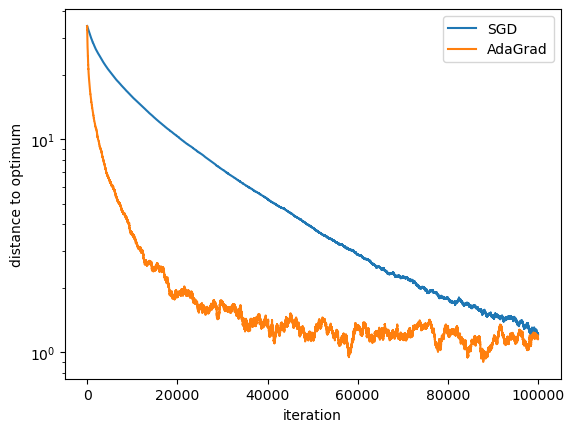

In [9]:
semilogy(dto; label="SGD");
semilogy(dto2; label="AdaGrad");
legend();
xlabel("iteration");
ylabel("distance to optimum");

Conclusion: AdaGrad can beat constant-step-size SGD for some problems, with equivalent hyperparameter optimization.